# Solvers for Additive-Noise SDEs
SDEs of the form
$$dX_t = f(t, X_t) \, dt + σ (t) \, dW_t$$
are said to have additive noise, since the matrix $\sigma$ in the noise term is independent of $X$. Such SDEs permit special solvers with a higher order of strong convergence than those for general SDEs. A few such solvers are presented below.

The high convergence rate of these solvers comes at the cost of requiring information about the Brownian motion's space-time Lévy area, defined as
$$
    H_{s,t} = \frac{1}{t-s}  \int_{s}^{t}  W_u - \frac{u - s}{t - s} W_{s,t} \; du.
$$
We modified the `VirtualBrownianTree` and the `UnsafeBrownianPath` to compute the increments of $H$ in addition to those of $W$. To enable this functionality, these objects must be initialised with `levy_area="space-time"`.


## Langevin diffusion
An example of an additive-noise SDE is the Langevin diffusion:
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \,
    \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t.
\end{align*}

Below we use four examples of Langevin-type SDEs to demonstrate the operation of our solvers.


# Solvers

## ALIGN
`ALIGN` has strong order 2 and is FSAL, meaning it only performs 1 evaulation of $\nabla f$ per step.
It can only be used for a Langevin SDE of the form
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \, \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t.
\end{align*}
ALIGN natively supports adaptive-stepping via an embedded method for error estimation.


## SORT
Similar to ALIGN, but also uses space-time-time Levy area in order to achieve strong order 3. Also only suitable for Langevin SDEs.
Uses three evaluations of the vector-field per step, but it is FSAL, so in practice it only uses two.
At this point it can only be used adaptively if a `HalfSolver` is used.


## ShOULD
`ShOULD` takes the 3rd order convergence from `SORT` and complements it with the improved trajectory computation from `ALIGN`. It can only be used for Langevin SDEs.


## ShARK
`ShARK` normally has strong order 1.5, but when applied to a Langevin SDE it has order 2. Unlike ALIGN or SORT it can be used for any additive-noise SDE.
 It has a better local error than SRA1. Uses two evaluations of the vector-field per step.

Based on equation (6.1) in
    Foster, J., dos Reis, G., & Strange, C. (2023).
    High order splitting methods for SDEs satisfying a commutativity condition.
    arXiv [Math.NA] http://arxiv.org/abs/2210.17543
    

## SRA1
`SRA1` normally has strong order 1.5, but when applied to a Langevin SDE it has order 2. It natively supports adaptive-stepping via an embedded method for error estimation. Uses two evaluations of the vector-field per step.

Based on the SRA1 method from
    A. Rößler, Runge–Kutta methods for the strong approximation of solutions of stochastic differential equations,
    SIAM Journal on Numerical Analysis, 8 (2010), pp. 922–952.
    

## Shifted Additive-noise Euler (SEA)
This variant of the Euler-Maruyama makes use of the space-time Levy area, which improves its local error to $O(h^2)$ compared to $O(h^{1.5})$ of the standard Euler-Maruyama.

In [1]:
%env JAX_PLATFORM_NAME=cuda

from test.helpers import (
    get_bqp,
    get_harmonic_oscillator,
    get_neals_funnel,
    get_uld3_langevin,
    simple_batch_sde_solve,
)
from typing import Literal

import diffrax
import jax.numpy as jnp
import jax.random as jr
from diffrax import (
    ALIGN,
    diffeqsolve,
    PIDController,
    ShARK,
    ShOULD,
    SORT,
)
from drawing_and_evaluating import (
    animated_funnel_plot,
    constant_step_strong_order,
    draw_order_multiple,
    load_order_results,
    pid_strong_order,
    plot_sol3D,
    plot_sol_langevin,
    remove_steps,
    save_order_results,  # noqa: F401
)
from jax import config


config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_disable_jit", False)
jnp.set_printoptions(precision=4, suppress=True)

dtype = jnp.float64
key = jr.PRNGKey(2)
num_samples = 5000
keys = jr.split(jr.PRNGKey(5678), num=num_samples)
keys_funnel = jr.split(jr.PRNGKey(77), 100)

t0, t1 = 0.0, 16.0
t_short = 4.0
t_long = 32.0
dt0 = 0.1
LevyArea = Literal["", "space-time", "space-time-time"]
levy_area: LevyArea = "space-time-time"


hosc = get_harmonic_oscillator(t0, t1, dtype=dtype)
terms_hosc = hosc.get_terms(hosc.get_bm(key, levy_area=levy_area, tol=2**-10))
hosc_short = get_harmonic_oscillator(t0, t_short, dtype=dtype)

bqp = get_bqp(t0, t1, dtype=dtype)
terms_bqp = bqp.get_terms(bqp.get_bm(key, levy_area=levy_area, tol=2**-10))
bqp_short = get_bqp(t0, t_short, dtype=dtype)

uld3_long = get_uld3_langevin(t0, t_long, dtype=dtype)
terms_uld3_long = uld3_long.get_terms(
    uld3_long.get_bm(key, levy_area=levy_area, tol=2**-10)
)
uld3 = get_uld3_langevin(t0, t1, dtype=dtype)
uld3_short = get_uld3_langevin(t0, t_short, dtype=dtype)

funnel = get_neals_funnel(t0, t_long, dtype=dtype)
terms_funnel = funnel.get_terms(
    funnel.get_bm(key, levy_area="space-time-time", tol=2**-12)
)

half_should = diffrax.HalfSolver(ShOULD(0.01))
half_sort = diffrax.HalfSolver(SORT(0.01))
half_heun = diffrax.HalfSolver(diffrax.Heun())
half_align = diffrax.HalfSolver(ALIGN(0.1))
half_shark = diffrax.HalfSolver(ShARK())
half_sra1 = diffrax.HalfSolver(diffrax.SRA1())

env: JAX_PLATFORM_NAME=cuda


# Experiments on different versions of the langevin SDE

## Neal's funnel

Neal's funnel is a 10-dimensional funnel-shaped distribution commonly used as test case for MCMC algorithms. The target distribution is given by
$$
    Z \sim \mathcal{N}(0, 3) \quad \text{and} \quad Y \sim \mathcal{N}(0, \exp(Z) \mathbf{I}_{9}).
$$
This is easy to sample from normally, but presents a challenge for MCMC methods to converge to, due to the narrow funnel shape.

We use the following Langevin SDE to sample from the funnel:
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \mathbf{v}_t \, dt - \,
    \nabla \log p \, ( \mathbf{x}_t ) \, dt + \sqrt{2} \, d W_t
\end{align*}

where $p$ is the target distribution.

In [2]:
# out_SORT_funnel_pid = pid_strong_order(
#     keys_funnel,
#     funnel,
#     half_sort,
#     (4, 20),
# )
# save_order_results(out_SORT_funnel_pid, "funnel_SORT_pid")
out_SORT_funnel_pid = load_order_results("funnel_SORT_pid")

# out_SORT_funnel_const = constant_step_strong_order(
#     keys_funnel, funnel, SORT(0.01), levels=(6, 12)
# )
# save_order_results(out_SORT_funnel_const, "funnel_SORT_const")
out_SORT_funnel_const = load_order_results("funnel_SORT_const")

# out_SRA1_funnel_pid = pid_strong_order(keys_funnel, funnel, half_sra1, (1, 11))
# save_order_results(out_SRA1_funnel_pid, "funnel_SRA1_pid")
out_SRA1_funnel_pid = load_order_results("funnel_SRA1_pid")

# out_Euler_funnel_const = constant_step_strong_order(
#     keys_funnel, funnel, diffrax.Euler(), (7, 13), bm_tol=2**-12
# )
# save_order_results(out_Euler_funnel_const, "funnel_Euler_const")
out_Euler_funnel_const = load_order_results("funnel_Euler_const")

out_SORT_funnel_pid = remove_steps(out_SORT_funnel_pid, 6, 0)
out_SORT_funnel_const = remove_steps(out_SORT_funnel_const, 0, 1)

Saved order_results/order_results_funnel_SORT_pid.npy
Loaded order_results/order_results_funnel_SRA1_pid.npy
Loaded order_results/order_results_funnel_Euler_const.npy


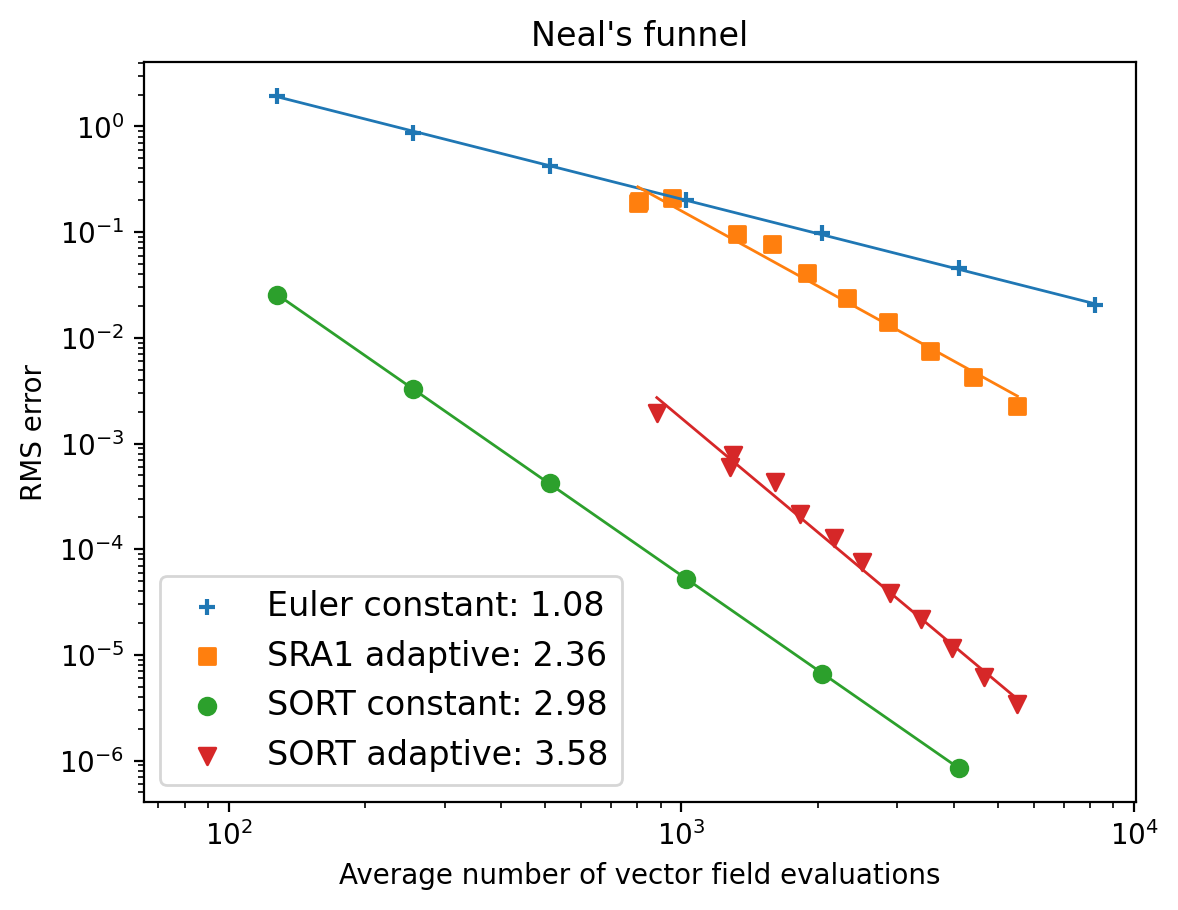

In [6]:
fig = draw_order_multiple(
    [
        out_Euler_funnel_const,
        out_SRA1_funnel_pid,
        out_SORT_funnel_const,
        out_SORT_funnel_pid,
    ],
    ["Euler constant", "SRA1 adaptive", "SORT constant", "SORT adaptive"],
    title="Neal's funnel",
)
fig.savefig("graphs/funnel_convergence.png")
fig.savefig("graphs/funnel_convergence.pdf")

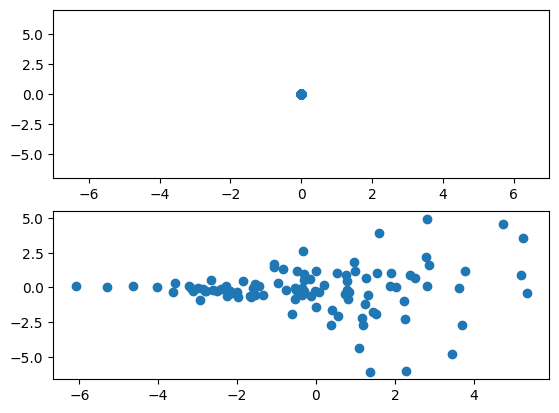

In [21]:
funnel_save_steps = jnp.linspace(t0, t_long, 2**9 + 1, endpoint=True)
pid_contr = PIDController(
    pcoeff=0.1,
    icoeff=0.3,
    rtol=0,
    atol=2**-10,
    step_ts=funnel_save_steps,
    dtmin=2**-14,
)
batch_solSORTfunnel = simple_batch_sde_solve(
    keys_funnel,
    funnel,
    half_sort,
    levy_area,
    None,
    controller=pid_contr,
    bm_tol=2**-16,
    saveat=diffrax.SaveAt(ts=funnel_save_steps),
)
ani, fig, ax = animated_funnel_plot(batch_solSORTfunnel)
ani.save("funnel.gif", writer="pillow")

## A 2D Harmonic Oscillator
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \, \mathbf{x}_t \, dt + \sqrt{2 \gamma u} \, d W_t
\end{align*}
where $\mathbf{x}_t, \mathbf{v}_t, W_t \in \mathbb{R}^2$.

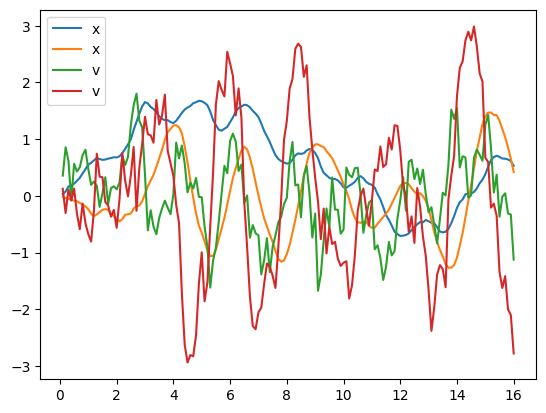

In [11]:
solALIGN = diffeqsolve(
    terms_hosc,
    ALIGN(0.1),
    t0,
    t1,
    dt0=dt0,
    y0=hosc.y0,
    args=hosc.args,
    saveat=diffrax.SaveAt(steps=True),
)
plot_sol_langevin(solALIGN)

In [24]:
out_ALIGN_hosc = constant_step_strong_order(keys, hosc_short, ALIGN(0.1), levels=(3, 8))
out_ShOULD_hosc = constant_step_strong_order(
    keys, hosc_short, ShOULD(0.01), levels=(3, 8)
)
out_SORT_hosc = constant_step_strong_order(keys, hosc_short, SORT(0.01), levels=(3, 8))
out_ShARK_hosc = constant_step_strong_order(keys, hosc_short, ShARK(), levels=(3, 8))

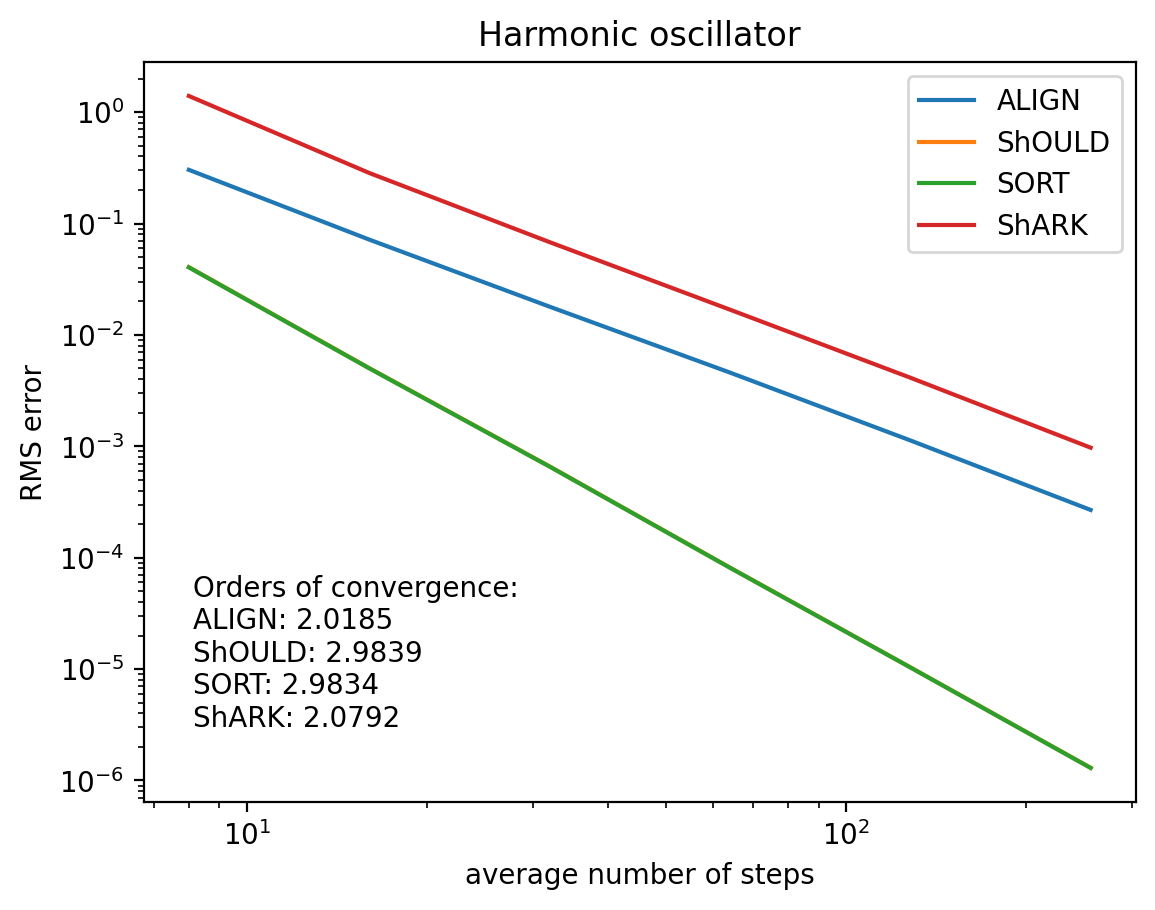

In [25]:
draw_order_multiple(
    [out_ALIGN_hosc, out_ShOULD_hosc, out_SORT_hosc, out_ShARK_hosc],
    ["ALIGN", "ShOULD", "SORT", "ShARK"],
    title="Harmonic oscillator",
)

## Particle in a Bistable Quartic Potential
\begin{align*}
    d x_t &= v_t \, dt \\
    d v_t &= - \gamma \, v_t \, dt - u \, \nabla \! f( x_t ) \, dt + \sqrt{2 \gamma u} \, d W_t
\end{align*}
where $x_t, v_t, W_t \in \mathbb{R}$ and $f(x) = (x-1)^2 (x+1)^2$.

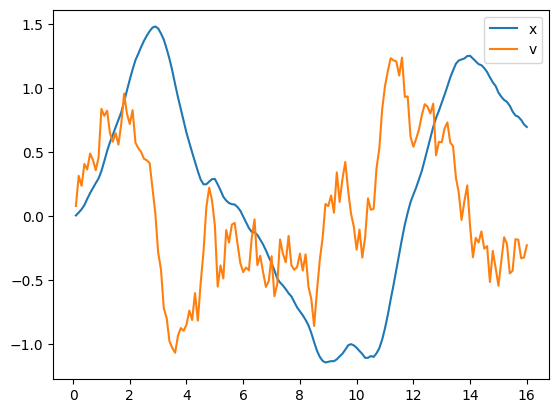

In [14]:
solALIGN_bqp = diffeqsolve(
    terms_bqp,
    ALIGN(0.1),
    t0,
    t1,
    dt0=dt0,
    y0=bqp.y0,
    args=bqp.args,
    saveat=diffrax.SaveAt(steps=True),
)
plot_sol_langevin(solALIGN_bqp)

In [26]:
out_ALIGN_bqp = constant_step_strong_order(keys, bqp_short, ALIGN(0.1), levels=(3, 8))
out_ShOULD_bqp = constant_step_strong_order(
    keys, bqp_short, ShOULD(0.01), levels=(3, 8)
)
out_SORT_bqp = constant_step_strong_order(keys, bqp_short, SORT(0.01), levels=(3, 8))
out_ShARK_bqp = constant_step_strong_order(keys, bqp_short, ShARK(), levels=(3, 8))

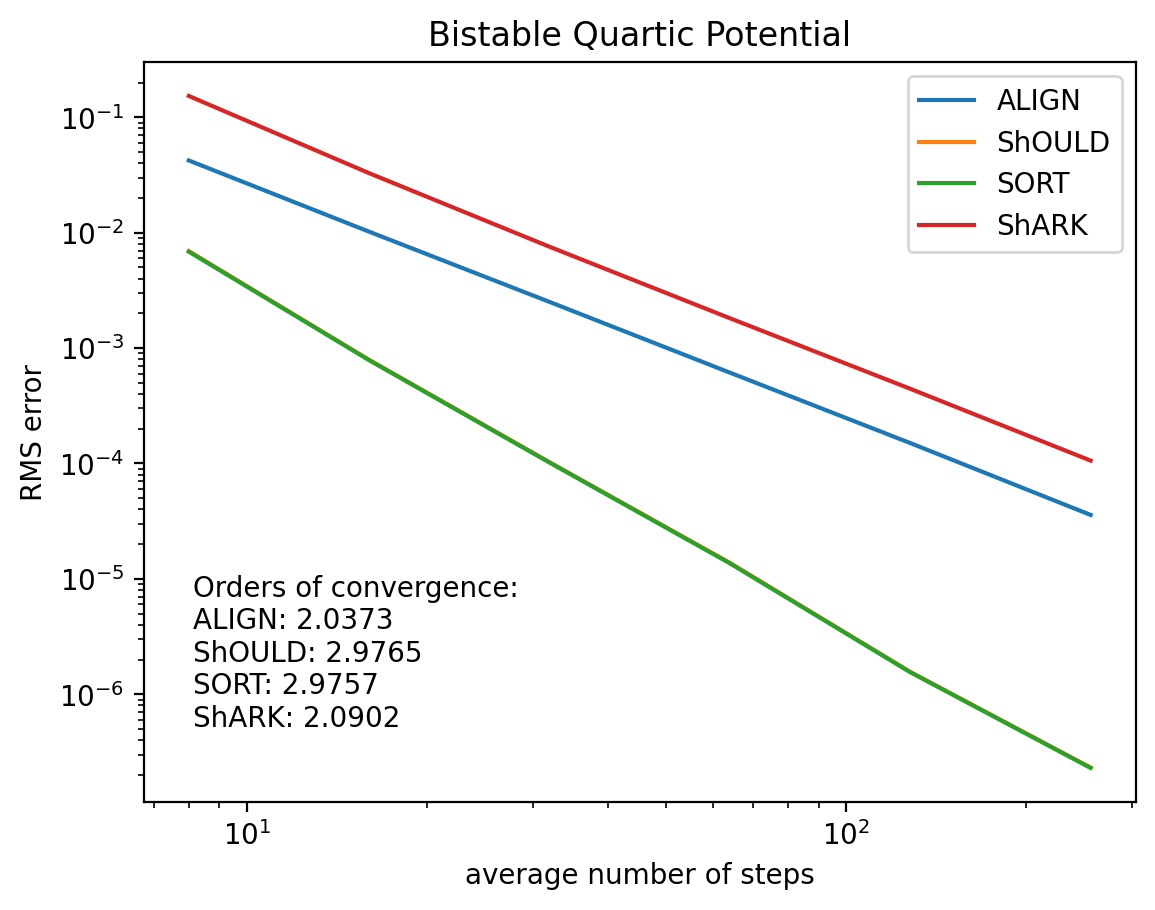

In [27]:
draw_order_multiple(
    [out_ALIGN_bqp, out_ShOULD_bqp, out_SORT_bqp, out_ShARK_bqp],
    ["ALIGN", "ShOULD", "SORT", "ShARK"],
    title="Bistable Quartic Potential",
)

## The "ULD3" Oscillator
Three particles in a 3D potential with three minima at (2, 2, 2), (-2, -2, -2) and (3, -1, 0).

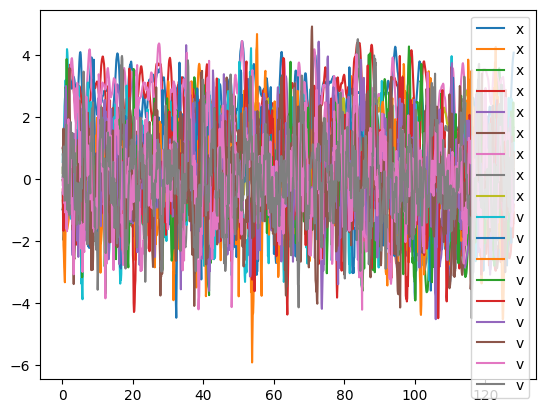

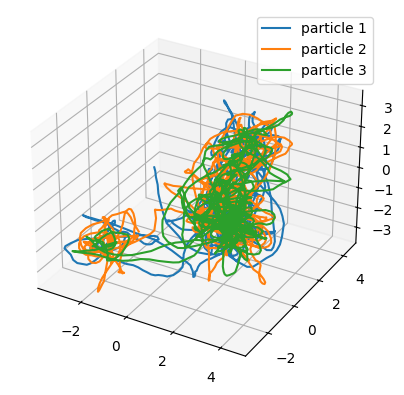

In [17]:
solALIGN_uld3 = diffeqsolve(
    terms_uld3_long,
    ALIGN(0.1),
    t0,
    t_long,
    dt0=dt0,
    y0=uld3_long.y0,
    args=uld3_long.args,
    saveat=diffrax.SaveAt(steps=True),
)
plot_sol_langevin(solALIGN_uld3)
plot_sol3D(solALIGN_uld3)

In [28]:
out_ALIGN_uld3 = constant_step_strong_order(keys, uld3_short, ALIGN(0.1), levels=(3, 8))
out_ShOULD_uld3 = constant_step_strong_order(
    keys, uld3_short, ShOULD(0.01), levels=(3, 8)
)
out_SORT_uld3 = constant_step_strong_order(keys, uld3_short, SORT(0.01), levels=(3, 8))
out_ShARK_uld3 = constant_step_strong_order(keys, uld3_short, ShARK(), levels=(3, 8))

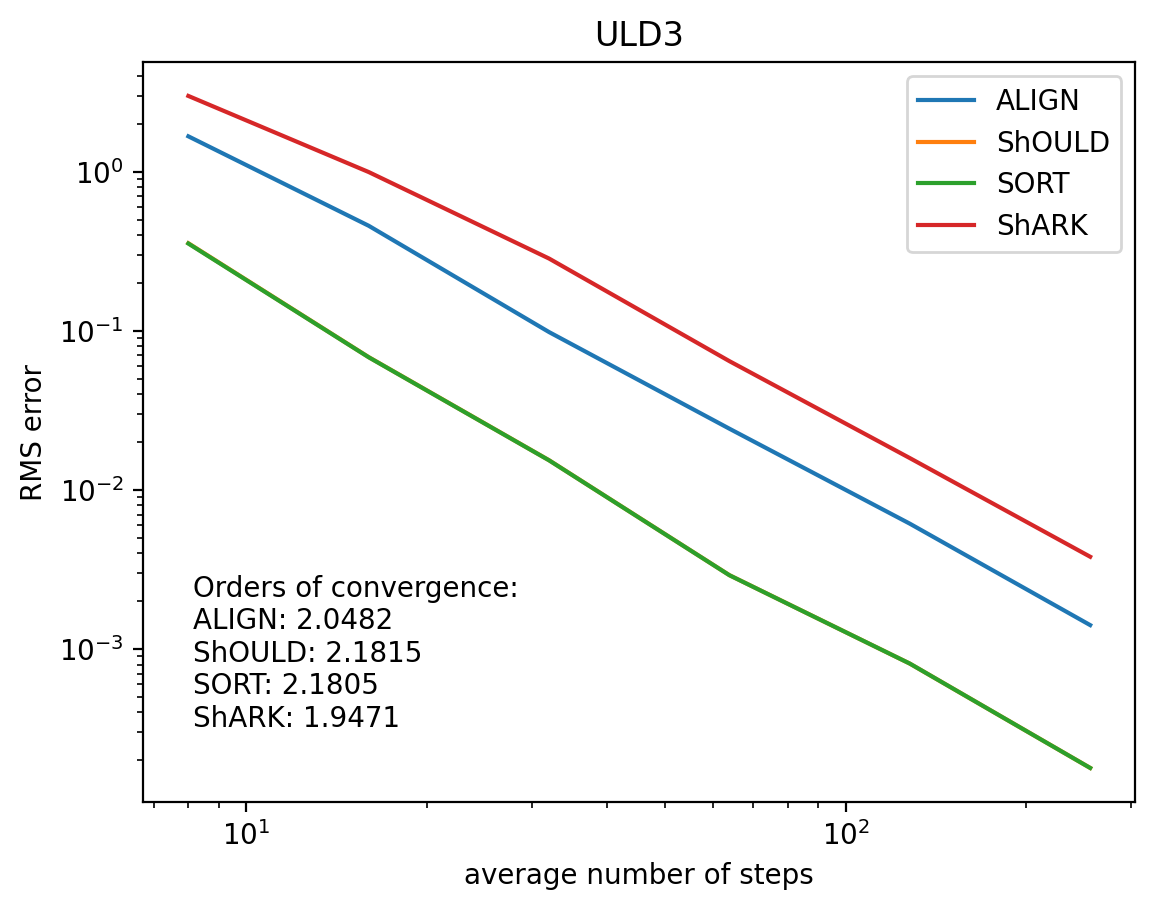

In [29]:
draw_order_multiple(
    [out_ALIGN_uld3, out_ShOULD_uld3, out_SORT_uld3, out_ShARK_uld3],
    ["ALIGN", "ShOULD", "SORT", "ShARK"],
    title="ULD3",
)

In [34]:
keys_large = jr.split(jr.PRNGKey(77), 200)
out_ShOULD_uld3_pid = pid_strong_order(
    keys_large,
    uld3,
    half_should,
    (-3, 14),
)
out_SORT_uld3_pid = pid_strong_order(keys_large, uld3, half_sort, (-3, 14))

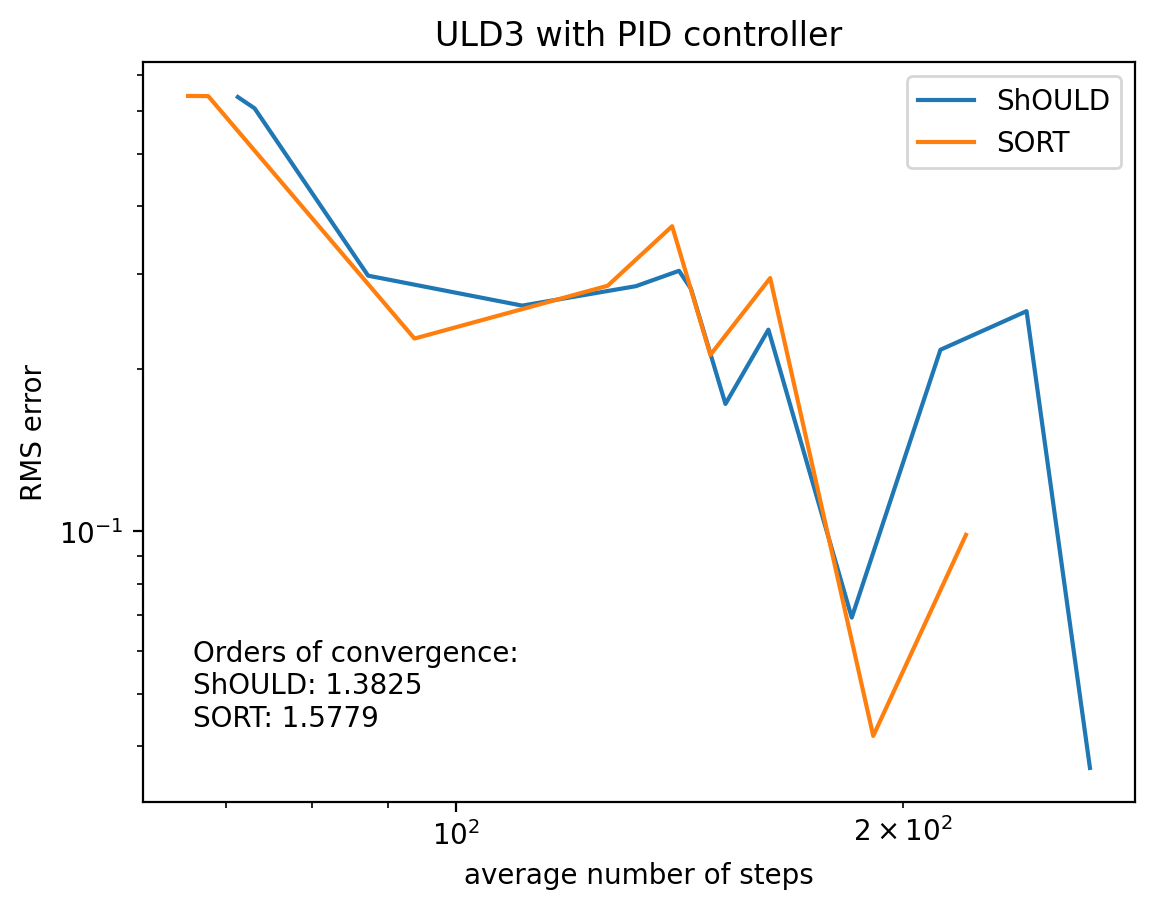

In [35]:
draw_order_multiple(
    [out_ShOULD_uld3_pid, out_SORT_uld3_pid],
    ["ShOULD", "SORT"],
    title="ULD3 with PID controller",
)

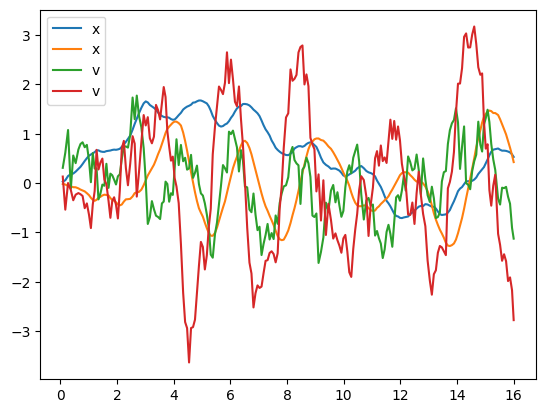

In [22]:
# Most of the methods presented above use an embeded method for error estimates,
# so they have native adaptive-stepping support
controller = PIDController(pcoeff=0.1, icoeff=0.3, rtol=0.005, atol=0.001)
solALIGN_PID = diffeqsolve(
    terms_hosc,
    ALIGN(0.1),
    t0,
    t1,
    dt0=dt0,
    y0=hosc.y0,
    args=hosc.args,
    saveat=diffrax.SaveAt(steps=True),
    stepsize_controller=controller,
)
plot_sol_langevin(solALIGN_PID)